=== UPDATED CLASS DISTRIBUTION ===
room_label
meeting_room    44
lab             24
hallway         20
kitchen         20
Name: count, dtype: int64

=== TRAIN/TEST SPLIT ===
Training samples: 81
Test samples: 27

=== TEST SET DISTRIBUTION ===
room_label
meeting_room    12
lab              6
hallway          5
kitchen          4
Name: count, dtype: int64

=== TRAINING RANDOM FOREST ===

=== MODEL PERFORMANCE ===
Accuracy: 1.0000

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     hallway       1.00      1.00      1.00         5
     kitchen       1.00      1.00      1.00         4
         lab       1.00      1.00      1.00         6
meeting_room       1.00      1.00      1.00        12

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27


=== CONFUSION MATRIX ===


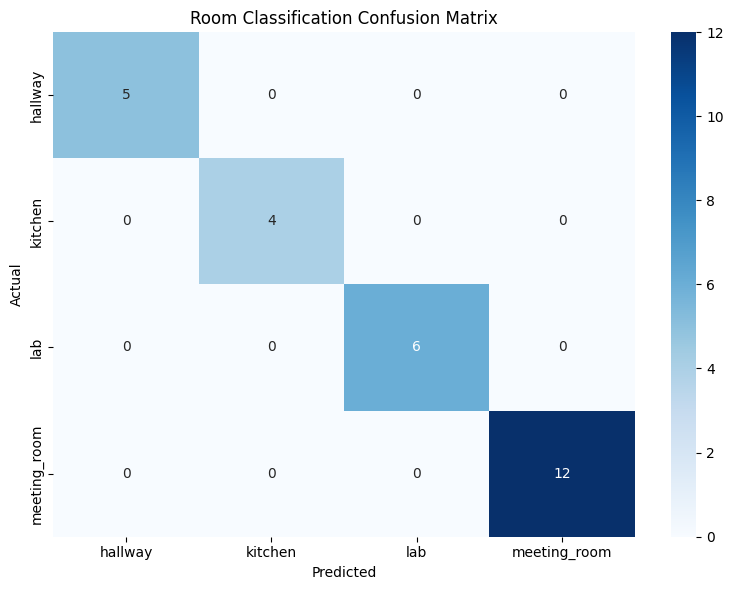


=== TOP 20 MOST IMPORTANT FEATURES ===
                                               feature  importance
108                         UO_Name_WINDOW_FRAME_count    0.043142
112      UO_Name_WINDOW_FRAME_EffectMesh_allocated_sum    0.034175
0                           UO_Type_Mesh_allocated_sum    0.023358
88            UO_Name_STORAGE_EffectMesh_allocated_sum    0.022561
177             AMO_UnityEngine_MeshRenderer_count_sum    0.021535
109                 UO_Name_WINDOW_FRAME_allocated_sum    0.020560
111              UO_Name_WINDOW_FRAME_EffectMesh_count    0.020159
3                            UO_Type_Mesh_resident_sum    0.019575
18                   UO_Type_MeshRenderer_resident_sum    0.017771
90                                 UO_Name_TABLE_count    0.017660
2                          UO_Type_Mesh_allocated_mean    0.015862
79                        UO_Name_SCREEN_allocated_sum    0.015443
84                               UO_Name_STORAGE_count    0.014871
6                   UO

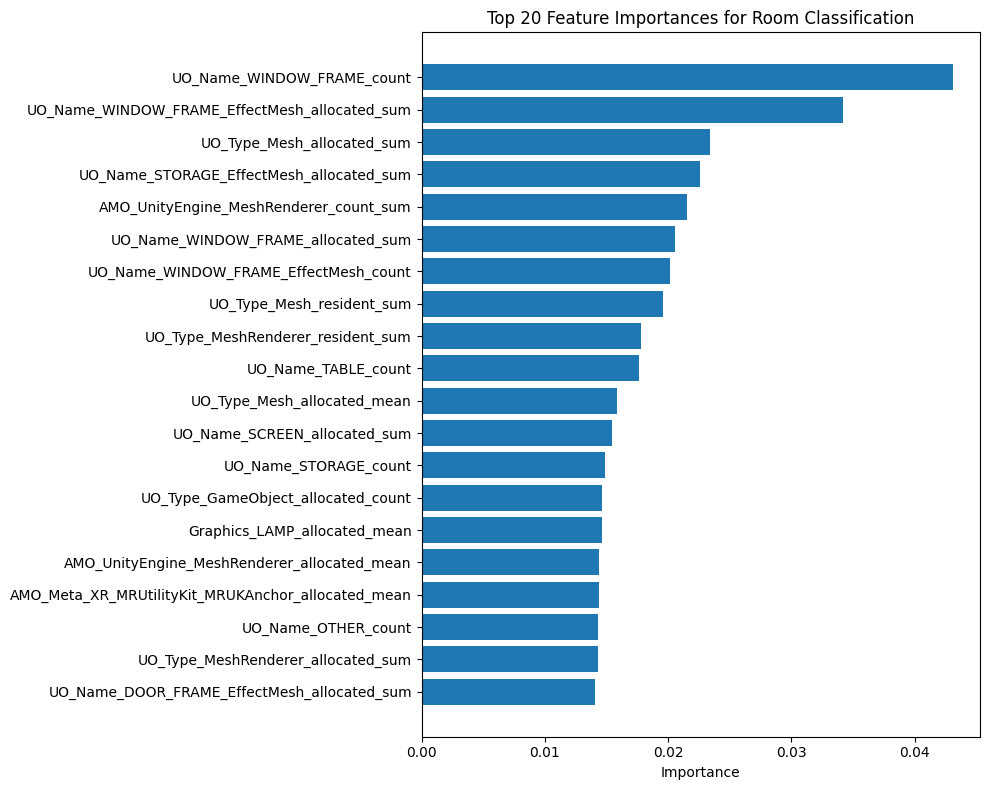

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('room_classification_features.csv')

# Combine blinds_up and blinds_down into "meeting_room"
df['room_label'] = df['room_label'].replace({
    'blinds_up': 'meeting_room',
    'blinds_down': 'meeting_room'
})

print("=== UPDATED CLASS DISTRIBUTION ===")
print(df['room_label'].value_counts())

# Prepare features and target
X = df.drop(columns=['room', 'room_label', 'trial'])
y = df['room_label']

# Update room column for stratification (combine blinds variants)
stratify_col = df['room'].replace({
    'blinds_up': 'meeting_room_base',
    'blinds_up_motion': 'meeting_room_motion',
    'blinds_up_person': 'meeting_room_person',
    'blinds_up_object': 'meeting_room_object',
    'blinds_down': 'meeting_room_base',
    'blinds_down_motion': 'meeting_room_motion',
    'blinds_down_person': 'meeting_room_person',
    'blinds_down_object': 'meeting_room_object',
})

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=stratify_col
)

print(f"\n=== TRAIN/TEST SPLIT ===")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print(f"\n=== TEST SET DISTRIBUTION ===")
print(y_test.value_counts())

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest Classifier
print(f"\n=== TRAINING RANDOM FOREST ===")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_model.predict(X_test_scaled)

# Evaluation
print(f"\n=== MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

print(f"\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(f"\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Room Classification Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Feature Importance
print(f"\n=== TOP 20 MOST IMPORTANT FEATURES ===")
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances for Room Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [10]:
# Verify no data leakage
print("DATA LEAKAGE CHECK")
print(f"Training indices: {sorted(X_train.index.tolist())[:10]}... (showing first 10)")
print(f"Test indices: {sorted(X_test.index.tolist())}")
print(f"Any overlap: {len(set(X_train.index) & set(X_test.index)) > 0}")

DATA LEAKAGE CHECK
Training indices: [0, 1, 2, 4, 5, 6, 8, 9, 10, 11]... (showing first 10)
Test indices: [3, 7, 12, 18, 23, 24, 27, 31, 35, 44, 46, 51, 52, 55, 65, 67, 69, 72, 75, 79, 82, 83, 85, 90, 98, 100, 106]
Any overlap: False


=== 5-FOLD CROSS-VALIDATION RESULTS ===
Fold accuracies: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0000
Std deviation: 0.0000
95% CI: 1.0000 ± 0.0000

=== AGGREGATED CLASSIFICATION REPORT (all folds combined) ===
              precision    recall  f1-score   support

     hallway       1.00      1.00      1.00        20
     kitchen       1.00      1.00      1.00        20
         lab       1.00      1.00      1.00        24
meeting_room       1.00      1.00      1.00        44

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108


=== AGGREGATED CONFUSION MATRIX ===


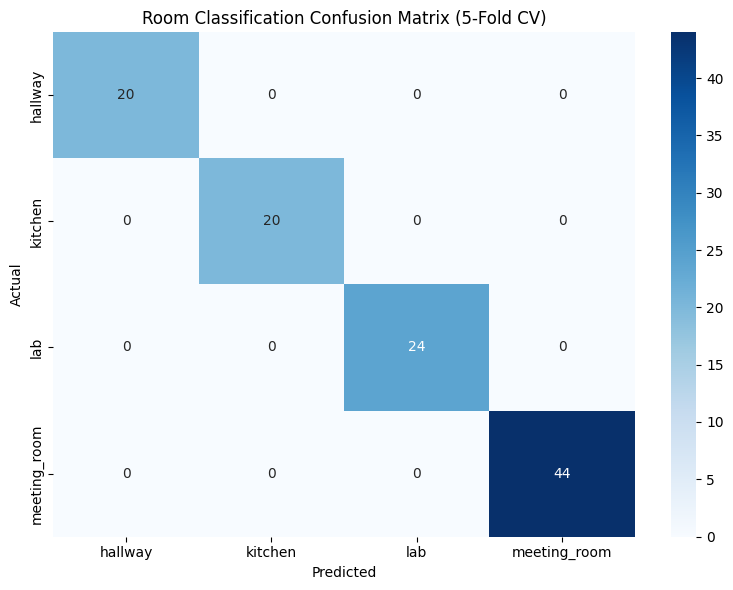

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load and prepare data
df = pd.read_csv('room_classification_features.csv')
df['room_label'] = df['room_label'].replace({
    'blinds_up': 'meeting_room',
    'blinds_down': 'meeting_room'
})

X = df.drop(columns=['room', 'room_label', 'trial'])
y = df['room_label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Get cross-validation scores
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=kfold, scoring='accuracy')

print("=== 5-FOLD CROSS-VALIDATION RESULTS ===")
print(f"Fold accuracies: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Std deviation: {cv_scores.std():.4f}")
print(f"95% CI: {cv_scores.mean():.4f} ± {1.96 * cv_scores.std():.4f}")

# Get predictions for ALL samples (each sample predicted when it was in test fold)
y_pred_cv = cross_val_predict(rf_model, X_scaled, y, cv=kfold)

print("\n=== AGGREGATED CLASSIFICATION REPORT (all folds combined) ===")
print(classification_report(y, y_pred_cv))

print("\n=== AGGREGATED CONFUSION MATRIX ===")
cm = confusion_matrix(y, y_pred_cv, labels=['hallway', 'kitchen', 'lab', 'meeting_room'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['hallway', 'kitchen', 'lab', 'meeting_room'],
            yticklabels=['hallway', 'kitchen', 'lab', 'meeting_room'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Room Classification Confusion Matrix (5-Fold CV)')
plt.tight_layout()
plt.savefig('confusion_matrix_kfold.png')
plt.show()

=== BOOTSTRAP RESULTS (1000 iterations) ===
Mean accuracy: 1.0000
Std deviation: 0.0000
95% CI: [1.0000, 1.0000]
Min accuracy: 1.0000
Max accuracy: 1.0000


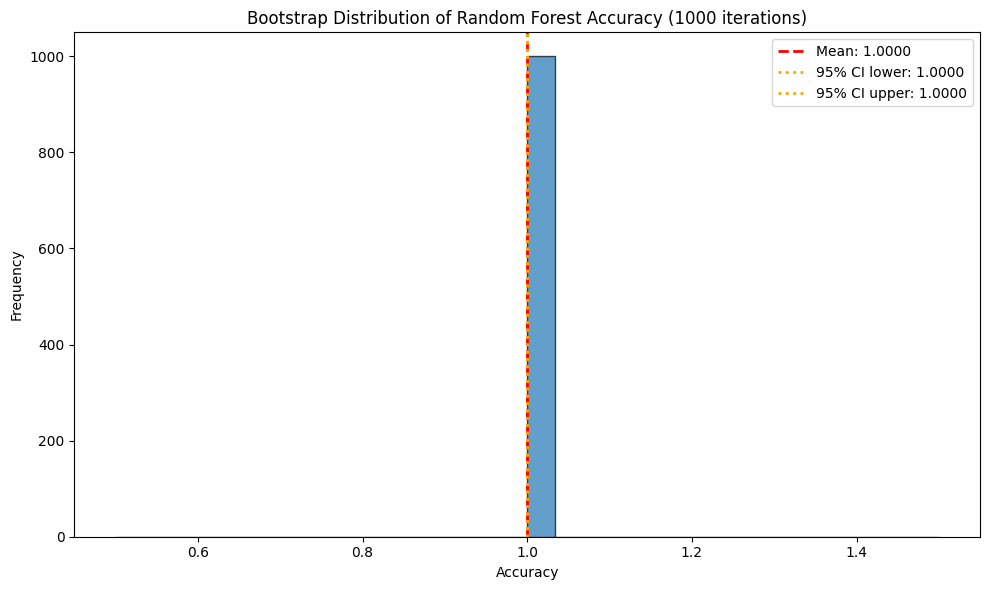

In [12]:
from sklearn.utils import resample
import numpy as np

# Load and prepare data
df = pd.read_csv('room_classification_features.csv')
df['room_label'] = df['room_label'].replace({
    'blinds_up': 'meeting_room',
    'blinds_down': 'meeting_room'
})

X = df.drop(columns=['room', 'room_label', 'trial'])
y = df['room_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bootstrap
n_iterations = 1000
bootstrap_accuracies = []
bootstrap_predictions = []

for i in range(n_iterations):
    # Sample with replacement for training
    indices = resample(range(len(X_scaled)), random_state=i)
    oob_indices = list(set(range(len(X_scaled))) - set(indices))  # Out-of-bag samples
    
    if len(oob_indices) < 5:  # Skip if too few OOB samples
        continue
    
    X_train = X_scaled[indices]
    y_train = y.iloc[indices]
    X_test = X_scaled[oob_indices]
    y_test = y.iloc[oob_indices]
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    acc = rf.score(X_test, y_test)
    bootstrap_accuracies.append(acc)

print("=== BOOTSTRAP RESULTS (1000 iterations) ===")
print(f"Mean accuracy: {np.mean(bootstrap_accuracies):.4f}")
print(f"Std deviation: {np.std(bootstrap_accuracies):.4f}")
print(f"95% CI: [{np.percentile(bootstrap_accuracies, 2.5):.4f}, {np.percentile(bootstrap_accuracies, 97.5):.4f}]")
print(f"Min accuracy: {np.min(bootstrap_accuracies):.4f}")
print(f"Max accuracy: {np.max(bootstrap_accuracies):.4f}")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(bootstrap_accuracies), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(bootstrap_accuracies):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 2.5), color='orange', linestyle=':', linewidth=2, label=f'95% CI lower: {np.percentile(bootstrap_accuracies, 2.5):.4f}')
plt.axvline(np.percentile(bootstrap_accuracies, 97.5), color='orange', linestyle=':', linewidth=2, label=f'95% CI upper: {np.percentile(bootstrap_accuracies, 97.5):.4f}')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Random Forest Accuracy (1000 iterations)')
plt.legend()
plt.tight_layout()
plt.savefig('bootstrap_accuracy.png')
plt.show()

In [13]:
from sklearn.model_selection import StratifiedKFold

# Load and prepare data
df = pd.read_csv('room_classification_features.csv')
df['room_label'] = df['room_label'].replace({
    'blinds_up': 'meeting_room',
    'blinds_down': 'meeting_room'
})

X = df.drop(columns=['room', 'room_label', 'trial'])
y = df['room_label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("=== VERIFYING NO DATA LEAKAGE IN K-FOLD ===\n")

for fold_num, (train_idx, test_idx) in enumerate(kfold.split(X_scaled, y), 1):
    print(f"Fold {fold_num}:")
    print(f"  Train indices: {sorted(train_idx)[:10]}... ({len(train_idx)} samples)")
    print(f"  Test indices: {sorted(test_idx)} ({len(test_idx)} samples)")
    
    # Check for overlap
    overlap = set(train_idx) & set(test_idx)
    print(f"  Overlap between train and test: {len(overlap)} samples")
    print()

=== VERIFYING NO DATA LEAKAGE IN K-FOLD ===

Fold 1:
  Train indices: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(8), np.int64(9), np.int64(10), np.int64(12), np.int64(13)]... (86 samples)
  Test indices: [np.int64(0), np.int64(3), np.int64(7), np.int64(11), np.int64(28), np.int64(30), np.int64(38), np.int64(43), np.int64(44), np.int64(51), np.int64(55), np.int64(60), np.int64(61), np.int64(62), np.int64(67), np.int64(73), np.int64(75), np.int64(78), np.int64(91), np.int64(101), np.int64(106), np.int64(107)] (22 samples)
  Overlap between train and test: 0 samples

Fold 2:
  Train indices: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]... (86 samples)
  Test indices: [np.int64(5), np.int64(14), np.int64(16), np.int64(19), np.int64(23), np.int64(24), np.int64(27), np.int64(29), np.int64(36), np.int64(37), np.int64(45), np.int64(57), np.int64(58), np.int64(66), np.int64(68)